# Introduction

Data analysis for the two-level system.  Detailed explanation in section 4.3 of thesis.

For the source of the data see measurement scripts:
  https://github.com/tychon/redpitaya-measurements

# Preamble

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib notebook


def rainbow(n, i, shift=0):
    """Helper function for plot colors with many lines.
    Returned colors indexed by i sample nipy spectral color map."""
    if n == 1: return plt.cm.nipy_spectral(0)
    x = i / (n-1) + shift
    return plt.cm.nipy_spectral(0.96 * (x % 1.01))


# Trigger time in data samples.
INIT_SAMPLE = 200
# Generate a warning when measurement data exceeds this limit
CLIPPING_WARNING = 10 # V


def load_u1drive1(inputfile, metalen=6):
    """Load data generated from u1_drive1.c measurement script."""
    data = pd.read_csv(inputfile, delimiter='\t', header=None).values
    assert np.all(np.absolute(data[:, metalen:] < CLIPPING_WARNING)), "Clipping values in "+fname
    return data

from numpy.fft import rfft, rfftfreq
from matplotlib.colors import LogNorm


def plot_spectrum(data, dcol, xscale, xlabel, fcenter=(31, 85), frange=10, vmin=3e-7, vmax=3e-3,
                  cmap='Purples', figsize=(6, 3.5)):
    """Plot the spectrum of the signal along the y axis and
    another quantity specified by `dcol` on the x axis.
    One subplot per channel.
    
    data (pandas.DataFrame)
    dcol (int): column index in data specifying x axis
    xscale (float): scale for `dcol`
    xlabel (string): label for x axis
    fcenter (list of floats): vertical axes are centered on these frequencies [kHz]
    frange (float): vertical axes ranges from fcenter-frange to fcenter+frange [kHz]
    vmin, vmax (float): min and max values in spectrum
    """
    # Need all samplerates to be the same
    assert np.allclose(data[:,0], data[0,0])
    
    samplerate = data[0,0]
    ffts = np.absolute(rfft(data[:,6:] * np.hamming(data.shape[1]-6), axis=1) / samplerate)
    fftbins = rfftfreq(data.shape[1]-6, 1/samplerate)
    
    fig, axs = plt.subplots(ncols=2, figsize=figsize, sharex=True, constrained_layout=True)
    axs[0].pcolormesh(
        data[::2,dcol]*xscale, fftbins/1e3, ffts[::2].T,
        norm=LogNorm(vmin=vmin, vmax=vmax),
        cmap=cmap, shading='auto')
    im = axs[1].pcolormesh(
        data[1::2,dcol]*xscale, fftbins/1e3, ffts[1::2].T,
        norm=LogNorm(vmin=vmin, vmax=vmax),
        cmap=cmap, shading='auto')
    axs[0].set_ylim(fcenter[0]-frange, fcenter[0]+frange)
    axs[1].set_ylim(fcenter[1]-frange, fcenter[1]+frange)
    axs[0].set_ylabel('f signal / kHz')
    axs[0].set_xlabel(xlabel)
    axs[1].set_xlabel(xlabel)
    axs[0].set_title('Site 1')
    axs[1].set_title('Site 2')
    fig.colorbar(im, ax=axs).set_label('Spectral density / V/Hz')

# Compare oscillator feedback

In [2]:
data1 = load_u1drive1('data_two-level/11-17 set1 u1_drive1.x 48e3,50,63e3 0.5 0 0.gz')
data2 = load_u1drive1('data_two-level/11-11 set2 u1_drive1.x 45e3,200,65e3 0.5 0 0.gz')
data3 = load_u1drive1('data_two-level/11-10 u1_drive1.x 45e3,100,65e3 0.5 0 0.gz')

Figure 25 from thesis:

> Spectrum of site 1 in 2-site configuration with driven link at V link =
0.5 V. (a) In resonators without oscillator feedback, the signal drops fast
producing a washed out peak at the resonance. (b) Close to critical feedback
there is a clear avoided crossing of two levels. (c) With the oscillators set to
an amplitude of 1 V, the feedback overpowers the beat close to resonance.

<IPython.core.display.Javascript object>


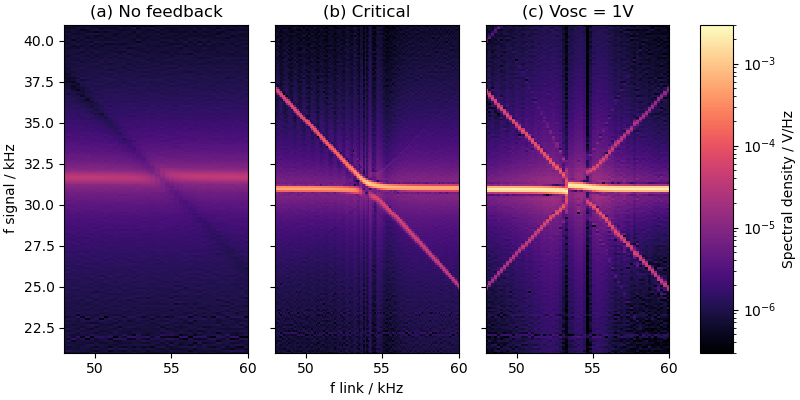

In [3]:
from numpy.fft import rfft, rfftfreq

cmap = 'magma'
q = 0.3, 1-1e-5
dcol = 1
xscale = 1e-3
ch = 0
fcenter = 31e3
frange = 10e3
xlabel = 'f link / kHz'

ffts1 = np.absolute(rfft(data1[:,6+INIT_SAMPLE:] * np.hamming(data1.shape[1]-6-INIT_SAMPLE), axis=1) / data1[0,0])
ffts2 = np.absolute(rfft(data2[:,6+INIT_SAMPLE:] * np.hamming(data2.shape[1]-6-INIT_SAMPLE), axis=1) / data2[0,0])
ffts3 = np.absolute(rfft(data3[:,6+INIT_SAMPLE:] * np.hamming(data3.shape[1]-6-INIT_SAMPLE), axis=1) / data3[0,0])
fftbins1 = rfftfreq(data1.shape[1]-6-INIT_SAMPLE, 1/data1[0,0])
fftbins2 = rfftfreq(data2.shape[1]-6-INIT_SAMPLE, 1/data2[0,0])
fftbins3 = rfftfreq(data3.shape[1]-6-INIT_SAMPLE, 1/data3[0,0])

vmin, vmax = 3e-7, 3e-3

fig, axs = plt.subplots(ncols=3, figsize=(8, 4), sharex=True, sharey=True, constrained_layout=True)
axs[0].pcolormesh(
    data1[ch::2,dcol]*xscale, fftbins1/1e3, ffts1[ch::2].T,
    norm=LogNorm(vmin=vmin, vmax=vmax),
    cmap=cmap, shading='auto')
axs[1].pcolormesh(
    data2[ch::2,dcol]*xscale, fftbins2/1e3, ffts2[::2].T,
    norm=LogNorm(vmin=vmin, vmax=vmax),
    cmap=cmap, shading='auto')
im = axs[2].pcolormesh(
    data3[ch::2,dcol]*xscale, fftbins3/1e3, ffts3[ch::2].T,
    norm=LogNorm(vmin=vmin, vmax=vmax),
    cmap=cmap, shading='auto')

axs[0].set_ylim((fcenter-frange)/1e3, (fcenter+frange)/1e3)
axs[0].set_xlim(48, 60)
axs[0].set_ylabel('f signal / kHz')
#axs[0].set_xlabel(xlabel)
axs[1].set_xlabel(xlabel)
#axs[2].set_xlabel(xlabel)

axs[0].set_title("(a) No feedback")
axs[1].set_title("(b) Critical")
axs[2].set_title("(c) Vosc = 1V")

plt.colorbar(im, ax=axs).set_label('Spectral density / V/Hz');

Next is figure 26 from thesis:

> Snippet of voltage signal corresponding to vertical line in figure 25 at a link
driving frequency of f link = 56.5 kHz. The full recording is 8.4 ms long at
a sample rate of 1.95 Msps. The trigger is located here at t = 0. The beat is
clearly visible, but also the strong dissipation without any feedback.

(100, 16390) (400, 16390) (200, 16390)
56571.429688
56557.789062
56515.15234400001


<IPython.core.display.Javascript object>


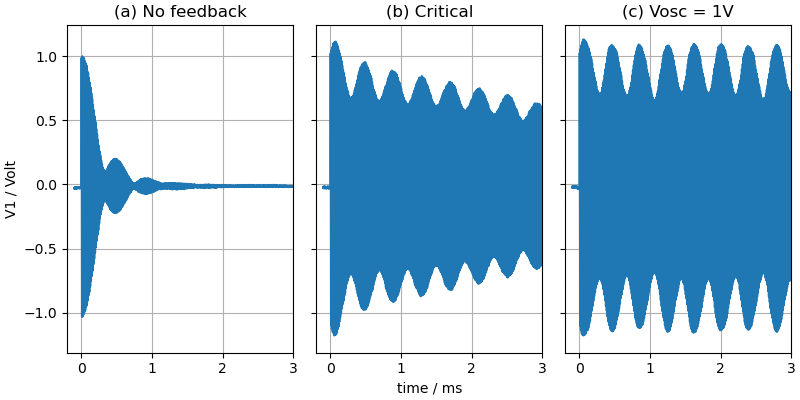

Text(0.5, 1.0, '(c) Vosc = 1V')

In [4]:
print(data1.shape, data2.shape, data3.shape)

site = 1
i1, i2, i3 = 28, 115, 57
print(data1[2*i1+site,1])
print(data2[2*i2+site,1])
print(data3[2*i3+site,1])

ts = (np.arange(data1.shape[1]-6) - INIT_SAMPLE) / data1[i1,0]
fig, axs = plt.subplots(ncols=3, figsize=(8, 4), sharex=True, sharey=True, constrained_layout=True)
axs[0].plot(ts*1e3, data1[2*i1+site,6:])
axs[1].plot(ts*1e3, data2[2*i2+site,6:])
axs[2].plot(ts*1e3, data3[2*i3+site,6:])

#c = plt.colorbar(im, ax=axs)
#c.set_label('Spectral density / V/Hz')
#c.ax.set_visible(False)

axs[0].grid(), axs[1].grid(), axs[2].grid()
axs[0].set_xlim(-0.2, 3)
axs[0].set_ylabel('V1 / Volt')
axs[0].set_ylabel('V1 / Volt')
axs[1].set_xlabel('time / ms')
axs[0].set_title("(a) No feedback")
axs[1].set_title("(b) Critical")
axs[2].set_title("(c) Vosc = 1V")

# Driving amplitude
Figure 27 from thesis:

> Effect of increasing the coupling by raising the link amplitude V link at
constant link frequency f link = 55 kHz. Side frequencies appear at the
detuning 1 kHz and move apart for stronger coupling.

In [5]:
data = load_u1drive1('data_two-level/11-11 set2 u1_drive1.x 55e3 0,50,1 0 0.gz')

<IPython.core.display.Javascript object>


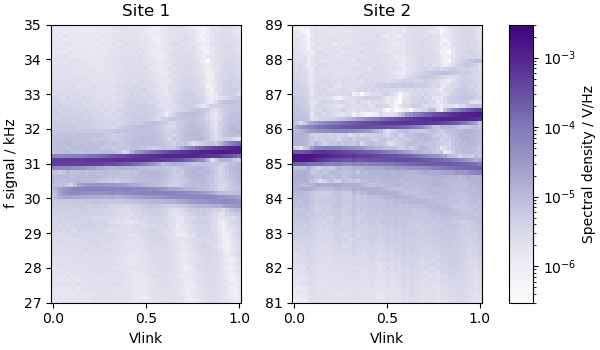

In [6]:
plot_spectrum(data, 2, 1, 'Vlink', frange=4)

# Fit avoided crossing to spectrum

Code for peak extraction from spectrum:

In [7]:
from scipy.signal import find_peaks, peak_widths


def twolevel_peaks(data, ch=0, min_dist=4, center=30e3, frange=20e3):
    """
    Find peaks in spectrum of two-level data.
    
    Returns: tuple of
      n x m array: Fourier transforms,
      m array: FT bin frequencies [Hz],
      k array: peak indexes in n data samples,
      k array: peak indexes in m fourier bins,
      k array: peak error (half width at half height) [Hz]
    """
    assert np.allclose(data[:,0], data[0,0])
    samplerate = data[0,0]
    ffts = np.absolute(rfft(data[ch::2,6:] * np.hamming(data.shape[1]-6), axis=1) / samplerate)
    fftbins = rfftfreq(data.shape[1]-6, 1/samplerate)
    
    peaks = [find_peaks(fft, distance=min_dist)[0] for fft in ffts]
    peaks = [ps[np.argsort(fft[ps])][::-1] for fft, ps in zip(ffts, peaks)]
    peaks = np.concatenate([
        [(i, ps[0]) for i, ps in enumerate(peaks) if len(ps) >= 1],
        [(i, ps[1]) for i, ps in enumerate(peaks) if len(ps) >= 2]
    ])
    
    remove = (fftbins[peaks[:,1]] < (center-frange)) | (fftbins[peaks[:,1]] > (center+frange))
    peaks = peaks[~remove]
    
    widths = np.array([peak_widths(ffts[i], [j])[0][0] for i, j in peaks])
    widths = widths * (fftbins[1] - fftbins[0]) # Hz
    
    return ffts, fftbins, peaks[:,0], peaks[:,1], widths/2


def twolevel_separate(fidx, pfs, defaulthi=True):
    """Assign peaks (specified as indices `fidx` in frequency bins) and corresponding
    frequency values `pfs` to a two-level structure.
    
    Returns two lists of frequency indices, for higher and lower levels."""
    fidx, pfs = fidx.tolist(), pfs.tolist()
    idxhi, idxlo = [], []
    for i, (idx1, f1) in enumerate(zip(fidx, pfs)):
        if idx1 in idxhi or idx1 in idxlo:
            continue
        potential_j = [j for j, idx2 in enumerate(fidx) if idx2 == idx1 and j != i]
        if len(potential_j) == 0:
            if defaulthi:
                idxhi.append(i)
            else:
                idxlo.append(i)
        elif len(potential_j) == 1:
            j = potential_j[0]
            f2 = pfs[j]
            if f1 >= f2:
                idxhi.append(i)
                idxlo.append(j)
            else:
                idxhi.append(j)
                idxlo.append(i)
        else:
            raise ValueError
    return np.array(idxhi), np.array(idxlo)

Code for fitting theoretical two-level to data:

In [8]:
from scipy.optimize import curve_fit

# Predicted levels for left and right sites
# and higher (hi) and lower (lo) levels:

def splitting_lefthi(flink, fsite1, fsite2, Ωb):
    δ = fsite1 + flink - fsite2
    μ = np.sqrt(δ**2 + 4 * Ωb**2)
    return fsite1 + μ/2 - δ/2

def splitting_leftlo(flink, fsite1, fsite2, Ωb):
    δ = fsite1 + flink - fsite2
    μ = np.sqrt(δ**2 + 4 * Ωb**2)
    return fsite1 - μ/2 - δ/2

def splitting_righthi(flink, fsite1, fsite2, Ωb):
    δ = fsite1 + flink - fsite2
    μ = np.sqrt(δ**2 + 4 * Ωb**2)
    return fsite2 + μ/2 + δ/2

def splitting_rightlo(flink, fsite1, fsite2, Ωb):
    δ = fsite1 + flink - fsite2
    μ = np.sqrt(δ**2 + 4 * Ωb**2)
    return fsite2 - μ/2 + δ/2


def splitting_fit(f, fdrive, fsignal, fsignalerr):
    popt, pcov = curve_fit(f, fdrive, fsignal, sigma=fsignalerr, absolute_sigma=True)
    perr = np.sqrt(np.diag(pcov))
    res = fsignal - f(fdrive, *popt)
    chi2 = np.sum(res**2 / fsignalerr**2)
    print('popt', popt)
    print('perr', perr)
    print('pcov', pcov)
    print('chi2red', chi2 / (fdrive.size-3))
    return popt, perr


def splitting_fit_both(data, ch=0, fcenter=30e3):
    """Fit two-level spectrum to measurements.
    Set `ch=0` for left site and `ch=1` for right site.
    Peaks far away from fcenter are ignored.
    
    Returns:
    ffts, fftbins: The spectrum data
    res (dict): the fit result
    """
    fs = data[::2,1]
    
    ffts, fftbins, fidx, peakidx, peakerr = twolevel_peaks(data, ch=ch, center=fcenter)
    idxhi, idxlo = twolevel_separate(fidx, fftbins[peakidx], defaulthi=True)
    # Frequencies in kHz for smaller numbers -> more stable fit
    res = {'hi': {}, 'lo': {}}
    res['hi']['fdrive'] = fs[fidx[idxhi]] / 1e3
    res['hi']['fsignal'] = fftbins[peakidx[idxhi]] / 1e3
    res['hi']['fsignalerr'] = peakerr[idxhi] / 1e3
    res['lo']['fdrive'] = fs[fidx[idxlo]] / 1e3
    res['lo']['fsignal'] = fftbins[peakidx[idxlo]] / 1e3
    res['lo']['fsignalerr'] = peakerr[idxlo] / 1e3
    
    if ch == 0:
        res['hi']['model'] = splitting_lefthi
        res['lo']['model'] = splitting_leftlo
    else:
        res['hi']['model'] = splitting_righthi
        res['lo']['model'] = splitting_rightlo
    
    for hl, name in [('hi', "UPPER"), ('lo', "LOWER")]:
        print()
        print(name)
        popt, perr = splitting_fit(
            res[hl]['model'], res[hl]['fdrive'],
            res[hl]['fsignal'], res[hl]['fsignalerr'])
        res[hl]['popt'] = popt
        res[hl]['perr'] = perr
    return ffts, fftbins, res

Load data and inspect envelopes:

In [9]:
data = load_u1drive1('data_two-level/11-11 set2 u1_drive1.x 49e3,20,61e3 0.8 0 0.gz')

Figure 28 from thesis:

>  Spectrum and fit of avoided crossing in 2-site configuration with driven
link at V link = 0.8 V and oscillator feedback near critical.

<IPython.core.display.Javascript object>


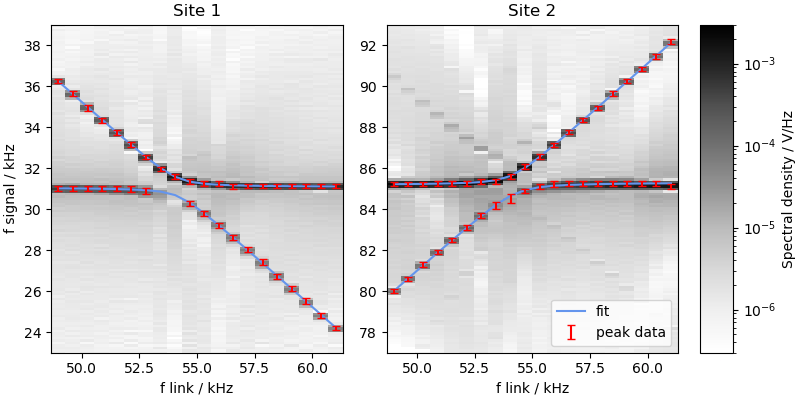


UPPER
popt [31.06848528 85.1770008   0.47512078]
perr [0.04750797 0.06123184 0.10021662]
pcov [[ 0.00225701  0.00134347 -0.00337052]
 [ 0.00134347  0.00374934 -0.00449701]
 [-0.00337052 -0.00449701  0.01004337]]
chi2red 0.05823172203505721

LOWER
popt [31.04229691 85.25103178  0.43331874]
perr [0.06332729 0.06155739 0.15685084]
pcov [[0.00401035 0.00199108 0.00699317]
 [0.00199108 0.00378931 0.00740623]
 [0.00699317 0.00740623 0.02460219]]
chi2red 0.06736267487356472

UPPER
popt [31.07726874 85.17189781  0.46112548]
perr [0.04938463 0.0586883  0.10269971]
pcov [[ 0.00243884  0.00133608 -0.00366676]
 [ 0.00133608  0.00344432 -0.00429416]
 [-0.00366676 -0.00429416  0.01054723]]
chi2red 0.08399562900511612

LOWER
popt [31.06363902 85.29761881  0.5497904 ]
perr [0.06665605 0.06290238 0.12471514]
pcov [[0.00444303 0.00221531 0.00634985]
 [0.00221531 0.00395671 0.00592529]
 [0.00634985 0.00592529 0.01555387]]
chi2red 0.18621246719546858


In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4), sharex=True, constrained_layout=True)

ffts, fftbins, res = splitting_fit_both(data, ch=0, fcenter=30e3)
vmin, vmax = 3e-7, 3e-3
frange = 8

ax = axs[0]
ax.clear()
ax.pcolormesh(
    data[::2,1]/1e3, fftbins/1e3, ffts.T,
    norm=LogNorm(vmin=vmin, vmax=vmax),
    cmap='Greys', shading='auto', zorder=0, label='spectrum')
for hl in ['hi', 'lo']:
    ax.errorbar(res[hl]['fdrive'], res[hl]['fsignal'], yerr=res[hl]['fsignalerr'],
                 capsize=3, fmt=' ', zorder=10, color='red', linewidth=1.5,
                 label='peak data' if hl == 'hi' else None)
    fs = data[::2,1] / 1e3
    ax.plot(fs, res[hl]['model'](fs, *res[hl]['popt']), color='cornflowerblue', linewidth=1.5, label=('fit' if hl=='hi' else None))

ax.set_ylim(31-frange, 31+frange)
ax.set_ylabel('f signal / kHz')
ax.set_xlabel('f link / kHz')
ax.set_title('Site 1')
res1 = res


ffts, fftbins, res = splitting_fit_both(data, ch=1, fcenter=85e3)

ax = axs[1]
ax.clear()
im = ax.pcolormesh(
    data[::2,1]/1e3, fftbins/1e3, ffts.T,
    norm=LogNorm(vmin=vmin, vmax=vmax),
    cmap='Greys', shading='auto', zorder=0, label='spectrum')
for hl in ['hi', 'lo']:
    ax.errorbar(res[hl]['fdrive'], res[hl]['fsignal'], yerr=res[hl]['fsignalerr'],
                 capsize=3, fmt=' ', zorder=10, color='red', linewidth=1.5,
                 label='peak data' if hl == 'hi' else None)
    fs = data[::2,1] / 1e3
    ax.plot(fs, res[hl]['model'](fs, *res[hl]['popt']), color='cornflowerblue', linewidth=1.5, label=('fit' if hl=='hi' else None))

ax.legend(loc='lower right')
ax.set_ylim(85-frange, 85+frange)
ax.set_xlabel('f link / kHz')
ax.set_title('Site 2')
res2 = res

fig.colorbar(im, ax=axs).set_label('Spectral density / V/Hz');

Combine all fits by averaging (see last column in table 2)

In [11]:
resboth = {
    'hi1': res1['hi'], 'lo1': res1['lo'],
    'hi2': res2['hi'], 'lo2': res2['lo']
}
popt = np.mean(np.vstack([r['popt'] for r in resboth.values()]), axis=0)
perr = np.sqrt(np.sum(np.vstack([r['perr'] for r in resboth.values()])**2, axis=0)) / 4
print(popt)
print(perr)

[31.06292249 85.2243873   0.47983885]
[0.02866752 0.03055699 0.06161709]


Additional calculations as described in section 4.3.3 of the thesis:

In [12]:
# all frequencies in kHz
f0 = 60
f1, f1err = 31.06, 0.02
f2, f2err = 85.22, 0.03
fΩb, fΩberr = 0.48, 0.06

flink, flinkerr = f2 - f1, np.sqrt(f1err**2+f2err**2)
print('flink', flink, flinkerr, flinkerr/flink)

Vlink, V0 = 0.8, 1
b = 1/(2 * flink / f0)**0.5 * Vlink/V0
berr = b * (flinkerr/flink)
print('b', b, berr)

Ωa = fΩb / (f0 * b)
Ωaerr = Ωa * np.sqrt((fΩberr/fΩb)**2 + (berr/b)**2)
print('Ωa', Ωa, Ωaerr, Ωaerr/Ωa)

Vref, Vreferr = 10.3, 0.02
Ωb = (f1 * flink * f2 / f0**3 / 2**5)**0.5 * V0/Vref
Ωberr = (
    (1/(2 * f1 * flink * f2 / f0**3)**0.5 * V0/Vref * f2*(f2-2*f1)/f0**3 * f1err)**2
  + (1/(2 * f1 * flink * f2 / f0**3)**0.5 * V0/Vref * f1*(f2-2*f1)/f0**3 * f2err)**2
  + (Ωb/Vref * Vreferr)**2
)**0.5
print('Ωb', Ωb, Ωberr, Ωberr/Ωb)

flink 54.16 0.03605551275463989 0.000665722170506645
b 0.5954033673628834 0.000396373222047784
Ωa 0.013436269323489066 0.001679557484333507 0.1250017727314629
Ωb 0.01398207827315953 3.230406902829058e-05 0.002310391087589787


Also calculate θ for beat properties:

In [13]:
flink = 56
θ = np.arctan(2*fΩb/(f1+flink-f2))
θerr = (
    (2*(f1+flink-f2)/((f1+flink-f2)**2-4*fΩb**2) * fΩberr)**2)**0.5
print('θ', θ, θerr)

fμ = ((f1 + flink - f2)**2 + 4 * fΩb**2)**0.5
fμerr = 0.5/fμ * (
    (2*(f1+flink-f2) * f1err)**2
  + (2*(f1+flink-f2) * f2err)**2
  + (8 * fΩb * fΩberr)**2
)**0.5
print('fμ', fμ, fμerr)

θ 0.480887280195335 0.08961038961038931
fμ 2.0753794833716586 0.06405444378184914


# Envelope: Beat phase

In [14]:
def angledist(α, βs):
    """Distance measure between two angles."""
    return np.absolute(((βs - α) + np.pi) % (2*np.pi) - np.pi)

def circular_mean(αs):
    """Mean of angles (see appendix A.2 of thesis)."""
    zs = np.exp(1j*αs)
    poly = np.zeros(len(αs)+1, dtype=complex)
    poly[0] = -1
    poly[-1] = np.prod(zs)
    roots = np.roots(poly)
    ds = np.array([angledist(np.angle(r), αs) for r in roots])
    d2 = np.sum(ds**2, axis=1)
    return np.angle(roots[np.argmin(d2)])

## Envelope extraction

In [15]:
from scipy.signal import savgol_filter, find_peaks
from scipy.interpolate import InterpolatedUnivariateSpline as Spline1D


def slice_compose(*slices):
    assert all(s.stop >= 0 for s in slices)
    return slice(
        sum(s.start for s in slices),
        slices[-1].stop + sum(s.start for s in slices[:-1]))

def slice_intersect(slices, data=None):
    """Calculate intersection of slices.
    Optionally return data inside intersection (first axis) of every slice."""
    # Assertion not necessary. Might be interesting to use in cases
    # where this assertion is not true ;)
    # assert all(s.step is None or s.step == 1 for s in slices)
    
    inters = slice(
        max(s.start for s in slices),
        min(s.stop for s in slices))
    assert inters.start <= inters.stop, "No intersection."
    
    if data:
        interd = [
            trace[inters.start-s.start:inters.stop-s.start,...]
            for s, trace in zip(slices, data)
        ]
        return inters, interd
    else:
        return inters


def envelope_spline(signal, samplerate, fexp, fbeatexp=None,
                    start_thresh=0.2, peak_height=0.02, quiet=False):
    """Optionally smooth signal, get peaks, optionally smooth peaks, make spline for envelope.
    
    Returns: tuple of
      time for each sample in seconds, 0s at trigger,
      spline object based on time in seconds,
      slice for time where spline is valid,
      rms error of envelope smoothing.
    """
    ts = (np.arange(signal.shape[0]) - INIT_SAMPLE) / samplerate
    
    # First smoothing: signal
    beginidx = np.argmax(signal > start_thresh)
    smoothwin = int(samplerate/fexp / 10)
    smoothwin -= 1 if smoothwin % 2 == 0 else 0
    if smoothwin > 3:
        if not quiet: print(f"  Signal: smoothing window: {smoothwin} samples")
        smoothed = savgol_filter(signal[beginidx:], window_length=smoothwin, polyorder=3)
    else:
        if not quiet: print(f"  Signal: no smoothing, window {smoothwin} samples !> 3")
        smoothed = signal[beginidx:]
    
    # Find peaks and fit spline (envelope).
    # Note that indexing for these arrays is offset by `beginidx`.
    peakidxs = find_peaks(smoothed, height=peak_height, distance=0.75*samplerate/fexp)[0]
    
    favg = (peakidxs.size-1) / (ts[beginidx+peakidxs[-1]] - ts[beginidx+peakidxs[0]])
    t_jitter = np.std(np.diff(ts[beginidx+peakidxs]))
    V_jitter = np.sqrt(np.mean((np.diff(smoothed[peakidxs]))**2))
    if not quiet:
        print(f"  Avg peak frequency: {favg/1e3:.3f} kHz")
        print(f"  Jitter of peak positions: {t_jitter*1e6:.5f} us ({1e-6/t_jitter:.2f} MHz)")
        print(f"  Jitter of peak heights:   {V_jitter:.4f} V")
    
    # Second smoothing: peaks
    if fbeatexp:
        smoothwin = int(favg/fbeatexp / 4)
        smoothwin -= 1 if smoothwin % 2 == 0 else 0
        if smoothwin > 3:
            if not quiet: print(f"  Peaks: smoothing window: {smoothwin} samples")
            smoothpeaks = savgol_filter(
                signal[beginidx:][peakidxs],
                window_length=smoothwin, polyorder=3)
            # RMS difference of smoothing
            rmserr = np.sqrt(np.mean((smoothpeaks - signal[beginidx:][peakidxs])**2))
            if not quiet:
                print(f"  RMS diff to spline: {rmserr*1e3:.2f} mV")
        else:
            if not quiet: print(f"  Peaks: no smoothing, window {smoothwin} samples !> 3")
            smoothpeaks = signal[beginidx:][peakidxs]
    else:
        smoothpeaks = signal[beginidx:][peakidxs]
    
    
    spline = Spline1D(ts[beginidx:][peakidxs], smoothpeaks, k=3)
    srange = slice(beginidx+peakidxs[0], beginidx+peakidxs[-1])
    
    
    return ts, spline, srange, V_jitter


def envelope_properties(ts, env, fbeatexp, fμ=None, fμerr=None, favgerr=None):
    samplerate = (ts.size-1) / (ts[-1] - ts[0])
    peaks = find_peaks(env, distance=0.8*samplerate/fbeatexp)[0]
    # Omit outmost peaks which might not be peaks
    peaks = peaks[1:-1]
    
    if len(peaks) < 2:
        return np.array([]), np.nan, np.nan, np.nan, np.nan, np.nan
    
    tjitter = np.std(np.diff(ts[peaks])) / np.sqrt(2)
    print(f"Beat: peak jitter: {tjitter*1e3:f} ms")
    
    # Frequency
    favg = (peaks.size - 1) / (ts[peaks[-1]] - ts[peaks[0]])
    if favgerr is None:
        favgerr = (peaks.size - 1) / (ts[peaks[-1]] - ts[peaks[0]])**2 * np.sqrt(2) * tjitter
    print(f"Beat: Avg peak frequency: {favg/1e3:f} ± {favgerr/1e3:f} kHz")
    
    if fμ is None and fμerr is None:
        fμ = favg
        fμerr = favgerr
    
    # Phase
    # envelope = a + b sin(μt + α)
    t1 = ts[peaks[0]]
    αs = -2*np.pi * fμ * ts[peaks] + np.pi/2
    αserr = 2*np.pi * np.sqrt((ts[peaks]*fμerr)**2 + (fμ*tjitter)**2)
    # https://en.wikipedia.org/wiki/Mean_of_circular_quantities
    α = circular_mean(αs)
    print(αs%(2*np.pi), '->', α)
    αerr = np.sqrt(np.sum(αserr**2)) / len(αs)
    print(f"Beat: Phase: {α*180/np.pi:.2f} ± {αerr*180/np.pi:.2f} deg")
    
    # Contrast by peak averages
    troughs = find_peaks(-env, distance=0.75*samplerate/fbeatexp)[0]
    troughs = troughs[1:-1]
    envmin, envmax = np.mean(env[troughs]), np.mean(env[peaks])
    cavg = (envmax - envmin) / (envmin + envmax)
    
    # Contrast by second peak.
    envmin, envmax = env[troughs[0]], env[peaks[1]]
    cfirst = (envmax - envmin) / (envmin + envmax)
    print(f"Beat: Contrast avg {cavg:.3f}, first {cfirst:.3f}")
    return peaks, favg, favgerr, α, αerr, cavg, cfirst

Plots

In [16]:
def plot_envelope(signal, samplerate, fexp, fbeatexp=None):
    ts, spline, srange, Vjitter = envelope_spline(signal, samplerate, fexp, fbeatexp)
    fig, axs = plt.subplots(nrows=2, sharex=True)
    axs[0].plot(ts*1e3, signal, '-', color='C0', label='signal')
    axs[0].plot(ts[srange]*1e3, spline(ts[srange]), '-', color='C2', label='envelope')
    axs[0].fill_between(ts[srange]*1e3, spline(ts[srange])-Vjitter, spline(ts[srange])+Vjitter, color='C2', alpha=0.4, label='V jitter')
    axs[0].legend()
    
    if fbeatexp is not None:
        contrastidx, contrast = rolling_contrast(ts[srange], spline, fbeatexp, Vjitter)
        axs[1].plot(ts[srange][contrastidx]*1e3, contrast[:,0])
        axs[1].fill_between(
            ts[srange][contrastidx]*1e3,
            contrast[:,0] - contrast[:,1],
            contrast[:,0] + contrast[:,1], alpha=0.4)
        axs[1].grid()
        axs[1].set_ylabel('Rolling contrast')
    axs[1].set_xlabel('t / ms')
    plt.show()


def plot_env_ensemble(data, fexp1=31e3, fexp2=85e3):
    n = data.shape[0]//2
    ts1, spline1, srange1 = [], [], []
    ts2, spline2, srange2 = [], [], []
    for i in range(n):
        r1 = envelope_spline(data[2*i,6:], data[2*i,0], fexp=fexp1, fbeatexp=None, quiet=True)
        r2 = envelope_spline(data[2*i+1,6:], data[2*i+1,0], fexp=fexp2, fbeatexp=None, quiet=True)
        ts1.append(r1[0]), spline1.append(r1[1]), srange1.append(r1[2])
        ts2.append(r2[0]), spline2.append(r2[1]), srange2.append(r2[2])

    fig, axs = plt.subplots(ncols=2)
    for i, (ts, spline, srange) in enumerate(zip(ts1, spline1, srange1)):
        axs[0].plot(ts[srange]*1e3, spline(ts[srange]), alpha=0.2, color=rainbow(n, i))
    for i, (ts, spline, srange) in enumerate(zip(ts2, spline2, srange2)):
        axs[1].plot(ts[srange]*1e3, spline(ts[srange]), alpha=0.2, color=rainbow(n, i))
    axs[0].set_ylabel('signal / V')
    axs[0].set_xlabel('time / ms')
    axs[1].set_xlabel('time / ms')
    axs[0].set_title('CH1')
    axs[1].set_title('CH2')
    plt.tight_layout()

## Beat phase

Prediction for phase of beat with illustration of impact of θ:

<IPython.core.display.Javascript object>


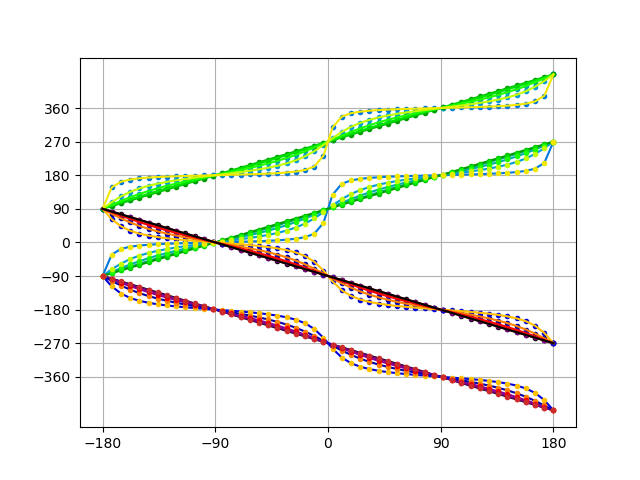

In [17]:
# if initial a1 = a2 then
# for site 1
def alphamodel(β, θ):
    α = np.arctan2(-np.sin(θ)*np.cos(θ)*np.cos(θ)*np.cos(β), np.sin(θ)*np.cos(θ)*np.sin(β))
    return np.unwrap(α)

# for site 2
def alphamodel2(β, θ):
    α = np.arctan2(np.sin(θ)*np.cos(θ)*np.cos(θ)*np.cos(β), -np.sin(θ)*np.cos(θ)*np.sin(β))
    return np.unwrap(α)

plt.figure()
βs = np.linspace(-180, 180, 50)
for i, θ in enumerate(np.linspace(-np.pi, np.pi, 20)):
    plt.plot(βs, alphamodel(βs/180*np.pi, θ)*180/np.pi, color=rainbow(20, i))
    plt.plot(βs, alphamodel2(βs/180*np.pi, θ)*180/np.pi, '.', color=rainbow(20, i))
plt.plot(βs, alphamodel(βs/180*np.pi, θ)*180/np.pi, 'k')
plt.xticks([-180, -90, 0, 90, 180])
plt.yticks([-360, -270, -180, -90, 0, 90, 180, 270, 360])
plt.grid()

Load data

In [18]:
data = load_u1drive1('data_two-level/11-11 set2 u1_drive1.x 56e3 0.8 -180,50,180 0.gz')

Get envelope and explicitly illustrate phase estimation.  
Note large difference in definitions (red, violet):

(100, 16390)
β -106.53060900000001 deg
  Signal: no smoothing, window 1 samples !> 3
  Avg peak frequency: 85.206 kHz
  Jitter of peak positions: 1.43165 us (0.70 MHz)
  Jitter of peak heights:   0.0249 V
  Peaks: smoothing window: 9 samples
  RMS diff to spline: 3.52 mV
Beat: peak jitter: 0.006324 ms
Beat: Avg peak frequency: 2.013185 ± 0.006041 kHz
[1.9475068  2.01335018 1.98204759 2.06084376 2.10725795 2.18605412
 1.9475068 ] -> 2.034938172197272
Beat: Phase: 116.59 ± 2.50 deg
Beat: Contrast avg 0.743, first 0.620
  Signal: smoothing window: 5 samples
  Avg peak frequency: 31.181 kHz
  Jitter of peak positions: 0.75661 us (1.32 MHz)
  Jitter of peak heights:   0.0185 V
  Peaks: no smoothing, window 3 samples !> 3
Beat: peak jitter: 0.021791 ms
Beat: Avg peak frequency: 2.053759 ± 0.025997 kHz
[5.21121179 5.31031566 5.56137879 4.96014865 4.68265782 5.21121179] -> -1.1270312236064377
Beat: Phase: -64.57 ± 10.35 deg
Beat: Contrast avg 0.084, first 0.004


<IPython.core.display.Javascript object>


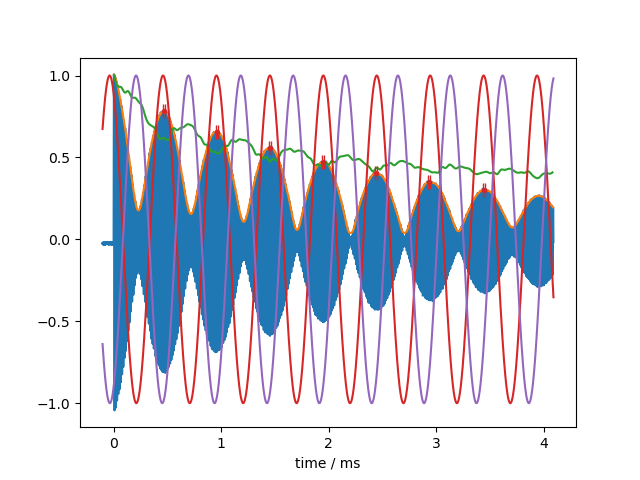

In [19]:
i = 2*10+1
fexp = 85e3
fbeatexp = 2e3

print(data.shape)
print('β', data[i,3], 'deg')
ts, spline, srange, _ = envelope_spline(data[i,6:data.shape[1]//2], data[i,0], fexp=fexp, fbeatexp=fbeatexp)
envpeaks = envelope_properties(ts, spline(ts), fbeatexp)#, fμ, fμerr)

ts2, spline2, srange2, _ = envelope_spline(data[i-1,6:data.shape[1]//2], data[i-1,0], fexp=35e3, fbeatexp=fbeatexp)
envpeaks2 = envelope_properties(ts2, spline2(ts2), fbeatexp)#, fμ, fμerr)

plt.figure()
plt.plot(ts*1e3, data[i,6:data.shape[1]//2])
plt.plot(ts[srange]*1e3, spline(ts[srange]))
plt.plot(ts2[srange2]*1e3, spline2(ts2[srange2]))
plt.errorbar(ts[envpeaks[0]]*1e3, spline(ts[envpeaks[0]]), xerr=0.009, #xerr=1e3/(10*fbeatexp),
             fmt='.', capsize=5)
plt.plot(ts*1e3, np.sin(2*np.pi * envpeaks[1] * ts + envpeaks[3]), 'C3')
#plt.plot(ts*1e3, np.sin(2*np.pi * fμ*1e3 * ts + envpeaks[3]), '--', color='C3')
plt.plot(ts*1e3, np.sin(2*np.pi * envpeaks2[1] * ts + envpeaks2[3]), 'C4')
plt.xlabel("time / ms");

Get envelopes for all runs in data set:

In [20]:
fbeatexp = 2e3 # Hz

βs = data[::2,3]
site = 0

ts, splines, sranges = [], [], []
for i in range(data.shape[0]):
    fexp = 31e3 if i % 2 == 0 else 85e3
    t, spline, srange, _ = envelope_spline(data[i,6:], data[i,0], fexp=fexp, fbeatexp=fbeatexp)
    ts.append(t), splines.append(spline), sranges.append(srange)

prop = pd.DataFrame([
    envelope_properties(t, spline(t), fbeatexp)[1:] #, fμ=fμ*1e3, fμerr=fμerr*1e3)[1:]
    for t, spline in zip(ts, splines)
], columns=['favg', 'favgerr', 'alpha', 'alphaerr', 'cavg', 'cfirst'])

  Signal: smoothing window: 5 samples
  Avg peak frequency: 31.186 kHz
  Jitter of peak positions: 0.77313 us (1.29 MHz)
  Jitter of peak heights:   0.0185 V
  Peaks: no smoothing, window 3 samples !> 3
  Signal: no smoothing, window 1 samples !> 3
  Avg peak frequency: 85.890 kHz
  Jitter of peak positions: 1.02271 us (0.98 MHz)
  Jitter of peak heights:   0.0185 V
  Peaks: smoothing window: 9 samples
  RMS diff to spline: 3.13 mV
  Signal: smoothing window: 5 samples
  Avg peak frequency: 31.184 kHz
  Jitter of peak positions: 0.83610 us (1.20 MHz)
  Jitter of peak heights:   0.0180 V
  Peaks: no smoothing, window 3 samples !> 3
  Signal: no smoothing, window 1 samples !> 3
  Avg peak frequency: 86.126 kHz
  Jitter of peak positions: 0.76598 us (1.31 MHz)
  Jitter of peak heights:   0.0184 V
  Peaks: smoothing window: 9 samples
  RMS diff to spline: 2.96 mV
  Signal: smoothing window: 5 samples
  Avg peak frequency: 31.188 kHz
  Jitter of peak positions: 0.80041 us (1.25 MHz)
  Jitte

  RMS diff to spline: 3.16 mV
  Signal: smoothing window: 5 samples
  Avg peak frequency: 31.184 kHz
  Jitter of peak positions: 0.82878 us (1.21 MHz)
  Jitter of peak heights:   0.0212 V
  Peaks: no smoothing, window 3 samples !> 3
  Signal: no smoothing, window 1 samples !> 3
  Avg peak frequency: 85.901 kHz
  Jitter of peak positions: 1.13595 us (0.88 MHz)
  Jitter of peak heights:   0.0175 V
  Peaks: smoothing window: 9 samples
  RMS diff to spline: 3.09 mV
  Signal: smoothing window: 5 samples
  Avg peak frequency: 31.184 kHz
  Jitter of peak positions: 0.85176 us (1.17 MHz)
  Jitter of peak heights:   0.0207 V
  Peaks: no smoothing, window 3 samples !> 3
  Signal: no smoothing, window 1 samples !> 3
  Avg peak frequency: 85.895 kHz
  Jitter of peak positions: 1.10293 us (0.91 MHz)
  Jitter of peak heights:   0.0177 V
  Peaks: smoothing window: 9 samples
  RMS diff to spline: 3.09 mV
  Signal: smoothing window: 5 samples
  Avg peak frequency: 31.188 kHz
  Jitter of peak positions:

Beat: peak jitter: 0.010048 ms
Beat: Avg peak frequency: 1.984883 ± 0.003999 kHz
[0.94503194 1.16213387 1.32176764 1.30899694 1.62826449 1.62187913
 1.67934729 1.68573264 1.67296194 1.55164027 1.59633773 1.37285045
 1.29622624 1.37285045 0.94503194] -> 1.4107368636851785
Beat: Phase: 80.83 ± 2.52 deg
Beat: Contrast avg 0.560, first 0.480
Beat: peak jitter: 0.050527 ms
Beat: Avg peak frequency: 1.982149 ± 0.020053 kHz
[5.01869142 4.81691896 4.83832597 5.33159814 5.53154873 4.72400342
 5.58711587 4.6711691  4.30360617 5.55568855 4.41018576 5.70690403
 4.3764811  5.66044626 5.01869142] -> -1.2464269802009789
Beat: Phase: -71.42 ± 12.89 deg
Beat: Contrast avg 0.072, first 0.041
Beat: peak jitter: 0.013497 ms
Beat: Avg peak frequency: 1.988058 ± 0.005389 kHz
[0.78688285 0.98149074 1.3807567  1.26198193 1.25193175 1.39537513
 1.43009391 1.33050583 1.24370888 1.33598774 1.25558636 1.21995393
 1.06920134 1.41090721 0.78688285] -> 1.2094164767876596
Beat: Phase: 69.29 ± 3.40 deg
Beat: Contrast 

 1.94552544 3.12876102 2.49967032] -> 3.063293193805028
Beat: Phase: 175.51 ± 11.10 deg
Beat: Contrast avg 0.124, first 0.152
Beat: peak jitter: 0.007845 ms
Beat: Avg peak frequency: 1.993130 ± 0.003148 kHz
[5.16694554 5.12160438 5.32632658 5.55028442 5.54341455 5.66478229
 5.86950449 5.79210393 5.64417268 5.52830083 5.61119729 5.5081492
 5.51410309 5.35334808 5.16694554] -> -0.7924397826188057
Beat: Phase: -45.40 ± 2.01 deg
Beat: Contrast avg 0.431, first 0.239
Beat: peak jitter: 0.036173 ms
Beat: Avg peak frequency: 2.028729 ± 0.014036 kHz
[2.39790908 2.46143273 1.97673857 2.00763021 2.53452844 1.94541183
 1.31061041 2.18993438 1.43765771 1.8470807  0.91206476 1.68043989
 1.47638104 1.93801525 1.22489699 2.39790908] -> 1.8586650671080798
Beat: Phase: 106.49 ± 8.93 deg
Beat: Contrast avg 0.115, first 0.137
Beat: peak jitter: 0.010382 ms
Beat: Avg peak frequency: 1.996477 ± 0.004180 kHz
[4.8949757  4.97388253 5.20051027 5.38217947 5.40328246 5.66844609
 5.58036405 5.42163288 5.42346793

Overview over beat properties:

<IPython.core.display.Javascript object>


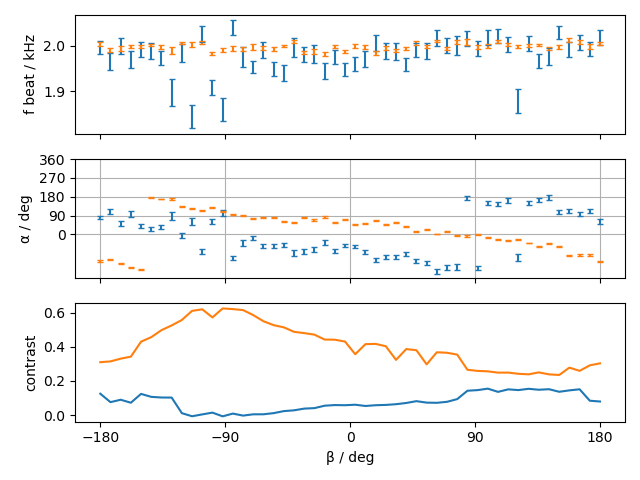

In [21]:
fig, axs = plt.subplots(nrows=3, sharex=True)
axs[0].errorbar(βs, prop[::2].favg/1e3, yerr=prop[::2].favgerr/1e3, fmt=' ', capsize=2)
axs[0].errorbar(βs, prop[1::2].favg/1e3, yerr=prop[1::2].favgerr/1e3, fmt=' ', capsize=2)
axs[1].errorbar(βs, prop[::2].alpha*180/np.pi, yerr=prop[::2].alphaerr*180/np.pi, fmt=' ', capsize=2)
axs[1].errorbar(βs, prop[1::2].alpha*180/np.pi, yerr=prop[1::2].alphaerr*180/np.pi, fmt=' ', capsize=2)
axs[2].plot(βs, prop[::2].cfirst)
axs[2].plot(βs, prop[1::2].cfirst)
axs[-1].set_xlabel('β / deg')
axs[0].set_ylabel('f beat / kHz')
axs[1].set_ylabel('α / deg')
axs[2].set_ylabel('contrast')

axs[2].set_xticks([-180, -90, 0, 90, 180])
axs[1].set_yticks([0, 90, 180, 270, 360])
axs[1].grid()

plt.tight_layout();

Compare measurement to prediction.  
Figure 29 from thesis:

> Phase α of beat depending on the phase β of the link. Grey lines show
predicted values based on fit data in table 2. For reference the estimated
beat frequency fμ is shown in the lower diagram.

<IPython.core.display.Javascript object>


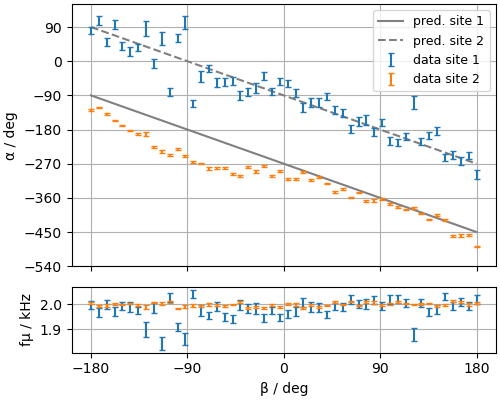

Text(0, 0.5, 'fμ / kHz')

In [22]:
θshift = np.pi

fig, axs = plt.subplots(nrows=2, figsize=(5, 4), constrained_layout=True, sharex=True,
                        gridspec_kw={'height_ratios': [4, 1]})
αdeg1 = np.unwrap(prop[::2].alpha)*180/np.pi
αdeg1[13:] = αdeg1[13:] - 360
axs[0].errorbar(βs, αdeg1, yerr=prop[::2].alphaerr*180/np.pi, fmt=' ', color='C0', capsize=2, label='data site 1', zorder=5)
axs[0].errorbar(βs, np.unwrap(prop[1::2].alpha)*180/np.pi, yerr=prop[1::2].alphaerr*180/np.pi, fmt=' ', color='C1', capsize=2, label='data site 2', zorder=5)
axs[0].plot(βs, alphamodel(-βs/180*np.pi, θ+θshift)*180/np.pi, '-', color='gray', label='pred. site 1')
axs[0].plot(βs, alphamodel2(-βs/180*np.pi, θ+θshift)*180/np.pi, '--', color='gray', label='pred. site 2')
axs[0].set_ylabel('α / deg')
axs[0].set_yticks([-540, -450, -360, -270, -180, -90, 0, 90])
axs[0].grid()
axs[0].legend(fontsize=9)

axs[1].errorbar(βs, prop[::2].favg/1e3, yerr=prop[::2].favgerr/1e3, fmt=' ', capsize=2)
axs[1].errorbar(βs, prop[1::2].favg/1e3, yerr=prop[1::2].favgerr/1e3, fmt=' ', capsize=2)
axs[1].set_xticks([-180, -90, 0, 90, 180])
axs[1].grid()
axs[1].set_xlabel('β / deg')
axs[1].set_ylabel('fμ / kHz')

## Conserved quantities

In [23]:
def topbot(ts, signal, fbeat):
    """Use peaks to get top and bottom range of signal, interpolated linearly between peaks."""
    samplerate = 1 / (ts[1] - ts[0])
    peakidxs = find_peaks(signal, distance=0.75*samplerate/fbeat)[0]
    troughidxs = find_peaks(-signal, distance=0.75*samplerate/fbeat)[0]
    srange = slice(max(np.min(peakidxs), np.min(troughidxs)), min(np.max(peakidxs), np.max(troughidxs)))
    top = np.interp(ts[srange], ts[peakidxs], signal[peakidxs])
    bot = np.interp(ts[srange], ts[troughidxs], signal[troughidxs])
    return srange, top, bot


def energy(V, Verr, C=20e-9):
    """Energy stored in capacitor at given Voltage."""
    return (
        C/2 * V**2,
        C * V * Verr
    )


def Gtot(V1, V2, V1err, V2err, f1=31e3, f2=85e3, f0=60e3, C=20e-9):
    """Number conservation [Joule]"""
    # Gtot = a1* a1 + a2* a2
    e1, err1 = energy(V1, V1err, C)
    e2, err2 = energy(V2, V2err, C)
    G = e1 * f0/f1 + e2 * f0/f2
    Gerr = np.sqrt((err1 * f0/f1)**2 + (err2 * f0/f2)**2)
    return G, Gerr

In [24]:
def plot_conservation(signal1, signal2, samplerate, fexp1=31e3, fexp2=85e3, fbeatexp=None, f0=60e3):
    # Take signal envelope
    print("CH1")
    ts1, spline1, srange1, Vjitter1 = envelope_spline(signal1, samplerate, fexp1, fbeatexp)
    print("CH2")
    ts2, spline2, srange2, Vjitter2 = envelope_spline(signal2, samplerate, fexp2, fbeatexp)
    
    ts = ts1
    srange = slice_intersect([srange1, srange2])
    
    # Energies
    V1 = spline1(ts[srange])
    V2 = spline2(ts[srange])
    V1err, V2err = Vjitter1, Vjitter2
    E1, E1err = energy(V1, V1err)
    E2, E2err = energy(V2, V2err)
    G, Gerr = Gtot(V1, V2, V1err, V2err, fexp1, fexp2, f0)
    
    # Ranges
    tstep = ts[1] - ts[0] # assume t linear
    winsize = int(1.5 / fbeatexp / tstep)
    centeridx1, range1 = rolling_range(ts, E1, E1err, winsize)
    centeridx2, range2 = rolling_range(ts, E2, E2err, winsize)
    Gcenteridx, Grange = rolling_range(ts, G, Gerr, winsize)
    
    fig, axs = plt.subplots(nrows=3, sharex=True)
    axs[0].plot(ts[srange1]*1e3, E1*1e9, color='C0', label='site 1')
    axs[0].fill_between(
        ts[srange]*1e3, (E1-E1err)*1e9, (E1+E1err)*1e9,
        color='C0', alpha=0.4)
    axs[0].plot(ts[srange]*1e3, E2*1e9, color='C1', label='site 2')
    axs[0].fill_between(
        ts[srange]*1e3, (E2-E2err)*1e9, (E2+E2err)*1e9,
        color='C1', alpha=0.4)
    axs[0].plot(ts[srange]*1e3, G*1e9, color='C2', label='Gtot')
    axs[0].fill_between(
        ts[srange]*1e3, (G - Gerr)*1e9, (G + Gerr)*1e9,
        color='C2', alpha=0.4, label='G error')
    axs[0].grid()
    axs[0].set_ylabel('Energy / nJ')
    axs[0].legend()
    
    #axs[1].plot(ts[srange][contrastidx]*1e3, contrast[:,0])
    axs[1].fill_between(
        ts[srange][centeridx1]*1e3,
        (range1[:,0] - range1[:,1])*1e9,
        (range1[:,0] + range1[:,1])*1e9, alpha=0.4, label='site 1')
    axs[1].fill_between(
        ts[srange][centeridx2]*1e3,
        (range2[:,0] - range2[:,1])*1e9,
        (range2[:,0] + range2[:,1])*1e9, alpha=0.4, label='site 2')
    axs[1].fill_between(
        ts[srange][Gcenteridx]*1e3,
        (Grange[:,0] - Grange[:,1])*1e9,
        (Grange[:,0] + Grange[:,1])*1e9, alpha=0.4, label='Gtot')
    axs[1].grid()
    axs[1].set_ylabel('Rolling top range / nJ')
    
    quality = Grange[:,0] / np.vstack([range1[:,0]*f0/fexp1, range2[:,0]*f0/fexp2]).max(axis=0)
    qualityerr = quality * np.sqrt((Grange[:,1] / Grange[:,0])**2 + ((range1[:,1]+range2[:,1])/(range1[:,0]+range2[:,0]))**2)
    axs[2].fill_between(
        ts[srange][Gcenteridx]*1e3,
        (quality-qualityerr), (quality+qualityerr),
        color='C2', alpha=0.5)
    axs[2].set_ylabel('G quality')
    
    axs[2].set_xlabel('t / ms')
    plt.tight_layout()
    plt.show()
    
    return ts[srange], E1, E2, G, E1err, E2err, Gerr

Load data and inspect:

<IPython.core.display.Javascript object>


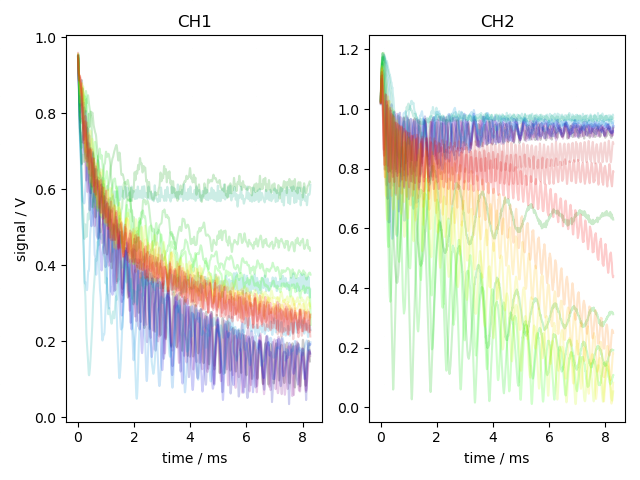

In [25]:
data = load_u1drive1('data_two-level/11-11 set2 u1_drive1.x 49e3,20,61e3 0.8 0 0.gz')
plot_env_ensemble(data)

Next, figure 30 from thesis:

> Violation of total number conservation in data taken at critical feedback,
f link = 56 kHz, and V link = 0.8 V. Shaded regions in the upper plot
indicate ranges of the beat, which are used to calculate the violation F
introduced in the text. F = 0 corresponds to perfect conservation. Values
above one indicate strong violation.


(40, 16390)
[1.95312500e+06 5.59473672e+04 8.00000000e-01 0.00000000e+00
 0.00000000e+00 1.00000000e+00]
δ 1947.3671880000038
CH1
  Signal: smoothing window: 5 samples
  Avg peak frequency: 31.194 kHz
  Jitter of peak positions: 0.77245 us (1.29 MHz)
  Jitter of peak heights:   0.0180 V
  Peaks: no smoothing, window 3 samples !> 3
CH2
  Signal: no smoothing, window 1 samples !> 3
  Avg peak frequency: 86.022 kHz
  Jitter of peak positions: 0.79441 us (1.26 MHz)
  Jitter of peak heights:   0.0196 V
  Peaks: smoothing window: 9 samples
  RMS diff to spline: 3.16 mV


<IPython.core.display.Javascript object>


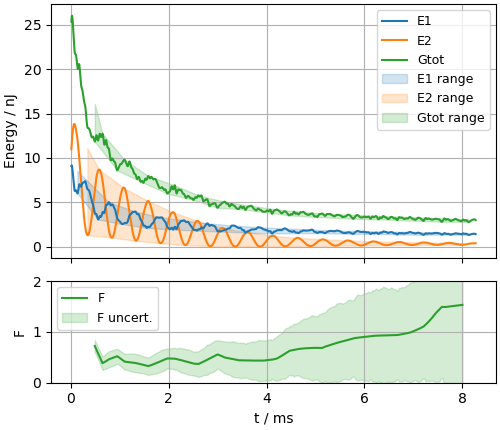

In [26]:
print(data.shape)

i = 11 * 2
print(data[i,:6])
δ = 31e3 + data[i,1] - 85e3
print('δ', δ)
fbeat = 2e3

fexp1, fexp2 = 31e3, 85e3
f0 = 60e3

samplerate = data[i,0]
signal1 = data[i,6:]
signal2 = data[i+1,6:]

# Take signal envelope
print("CH1")
ts1, spline1, srange1, Vjitter1 = envelope_spline(signal1, samplerate, fexp1, fbeat)
print("CH2")
ts2, spline2, srange2, Vjitter2 = envelope_spline(signal2, samplerate, fexp2, fbeat)

ts = ts1
srange = slice_intersect([srange1, srange2])

# Energies
V1 = spline1(ts[srange])
V2 = spline2(ts[srange])
V1err, V2err = Vjitter1, Vjitter2
E1, E1err = energy(V1, V1err)
E2, E2err = energy(V2, V2err)
# G = e1 * f0/f1 + e2 * f0/f2
G, Gerr = Gtot(V1, V2, V1err, V2err, fexp1, fexp2, f0)

# Ranges
range1, E1top, E1bot = topbot(ts[srange1], E1, fbeat)
range2, E2top, E2bot = topbot(ts[srange2], E2, fbeat)
rangeG, Gtop, Gbot = topbot(ts[srange], G, fbeat)

# unify ranges
rangeF, [E1topbot, E2topbot, Gtopbot] = slice_intersect(
    [slice_compose(srange, range1), slice_compose(srange, range2), slice_compose(srange, rangeG)],
    [np.vstack([E1top, E1bot]).T, np.vstack([E2top, E2bot]).T, np.vstack([Gtop, Gbot]).T])
reslice = slice(rangeF.start-srange.start, rangeF.stop-srange.start)
E1errF, E2errF, GerrF = E1err[reslice], E2err[reslice], Gerr[reslice]
# calculate quality
r1, r2, rG = E1topbot[:,0]-E1topbot[:,1], E2topbot[:,0]-E2topbot[:,1], Gtopbot[:,0]-Gtopbot[:,1]
F = 2*rG / (r1*f0/fexp1 + r2*f0/fexp2)
s2 = np.sqrt(2)
Ferr = np.sqrt(
    (2/(r1*f0/fexp1+r2*f0/fexp2) * s2*GerrF)**2
  + (2*rG/(r1*f0/fexp1+r2*f0/fexp2)**2 * ((s2*E1errF*f0/fexp1)**2 + (s2*E2errF*f0/fexp1)**2)))

fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(5, 4.3), constrained_layout=True,
                        gridspec_kw={'height_ratios': [2.5, 1]})
axs[0].plot(ts[srange1]*1e3, E1*1e9, color='C0', label='E1', zorder=4)
#axs[0].fill_between(
#    ts[srange]*1e3, (E1-E1err)*1e9, (E1+E1err)*1e9,
#    color='C0', alpha=0.4)
axs[0].fill_between(
    ts[srange1][range1]*1e3, E1bot*1e9, E1top*1e9,
    color='C0', alpha=0.2, zorder=2, label='E1 range')

axs[0].plot(ts[srange]*1e3, E2*1e9, color='C1', label='E2', zorder=3)
#axs[0].fill_between(
#    ts[srange]*1e3, (E2-E2err)*1e9, (E2+E2err)*1e9,
#    color='C1', alpha=0.4)
axs[0].fill_between(
    ts[srange2][range2]*1e3, E2bot*1e9, E2top*1e9,
    color='C1', alpha=0.2, zorder=1, label='E2 range')

axs[0].plot(ts[srange]*1e3, G*1e9, color='C2', label='Gtot')
#axs[0].fill_between(
#    ts[srange]*1e3, (G - Gerr)*1e9, (G + Gerr)*1e9,
#    color='C2', alpha=0.4, label='G error')
axs[0].fill_between(
    ts[srange][rangeG]*1e3, Gbot*1e9, Gtop*1e9,
    color='C2', alpha=0.2, zorder=-10, label='Gtot range')

axs[0].grid()
axs[0].set_ylabel('Energy / nJ')
axs[0].legend(fontsize=9)

axs[1].plot(ts[rangeF]*1e3, F, color='C2', label='F')
axs[1].fill_between(ts[rangeF]*1e3, F-Ferr, F+Ferr, color='C2', alpha=0.2, label='F uncert.')
axs[1].set_ylim(0, 2)
axs[1].grid()
axs[1].legend(fontsize=9)
axs[1].set_ylabel('F')
axs[1].set_xlabel('t / ms');

# Complex root and circular mean
Illustration for appendix A.2

[11.72015523  6.78535303 16.65495743 16.65495743]


<IPython.core.display.Javascript object>


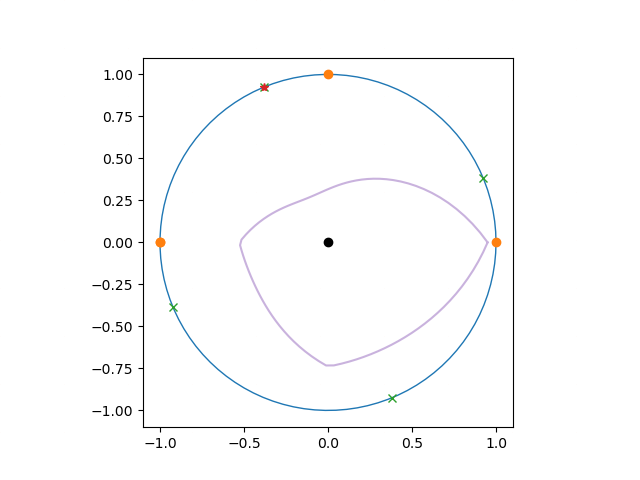

In [27]:
αs = np.array([0, 180, 180, 90]) / 180*np.pi
zs = np.exp(1j*αs)
poly = np.zeros(len(αs)+1, dtype=complex)
poly[0] = -1
poly[-1] = np.prod(zs)
roots = np.roots(poly)

def angledist(α, βs):
    return np.absolute(((βs - α) + np.pi) % (2*np.pi) - np.pi)
rdist = np.array([angledist(np.angle(r), αs) for r in roots])
rsq = np.sum(rdist**2, axis=1)
print(rsq)

root = roots[np.argmin(rsq)]

plt.figure()
x = np.linspace(0, 2*np.pi, 100)
d = np.array([np.sum(angledist(e, αs)**2) for e in x])
d = 0.95 * d / np.max(d)
plt.plot(np.cos(x), np.sin(x), linewidth=1)
plt.plot(zs.real, zs.imag, 'o')

plt.plot(roots.real, roots.imag, 'x')
plt.plot([root.real], [root.imag], '*')

plt.plot(d*np.cos(x), d*np.sin(x), alpha=0.5)
plt.plot([0], [0], 'ko')
plt.gca().set_aspect('equal')